In [1]:
# python v3.11.8
# import necessary packages

import os
import sys

import pandas as pd
import numpy as np

sys.path.append('functions')

from greatbrowser import great_analysis

from gene_analysis_functions import get_cistrome, get_pos, insig_nan
from pseudoinverse_functions import pinv_dropmin, quality_filter, trait_cluster, count_cumulative_probes

%matplotlib inline
%load_ext autoreload
%autoreload 2

Establish the CWD, import relevant data, and perform basic formatting

In [73]:
# set directory, import data, drop undefined
os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\raw_data')
#os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\raw_data')

data = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0) # mm39
data = data.dropna()

# referring to the point in the data where methylation and phenotype data diverge
sep=55

# seperate trait and methylation data
trait_data = data[:sep]
meth_data = data[sep:]

print(f'{trait_data.shape[0]} traits')

55 traits


Scale (not normalize) each row by dividing it by its standard deviation

In [74]:
# avoid scaling the categorical variables
no_categorical = trait_data.drop(['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?'])

# divide each row (trait) by its standard deviation
trait_data_std = no_categorical.div(no_categorical.std(axis='rows'))

# add the categorical variables back to the dataframe
categorical_vars = trait_data.loc[['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?']]
trait_data_std = pd.concat([trait_data_std, categorical_vars], axis=0)

Filter the trait data to remove collinearity

In [75]:
filter = 0.70
f_trait_data = quality_filter(trait_data, filter)

print(f'{f_trait_data.shape[0]} traits')

24 traits


Generate pseudoinversion plots

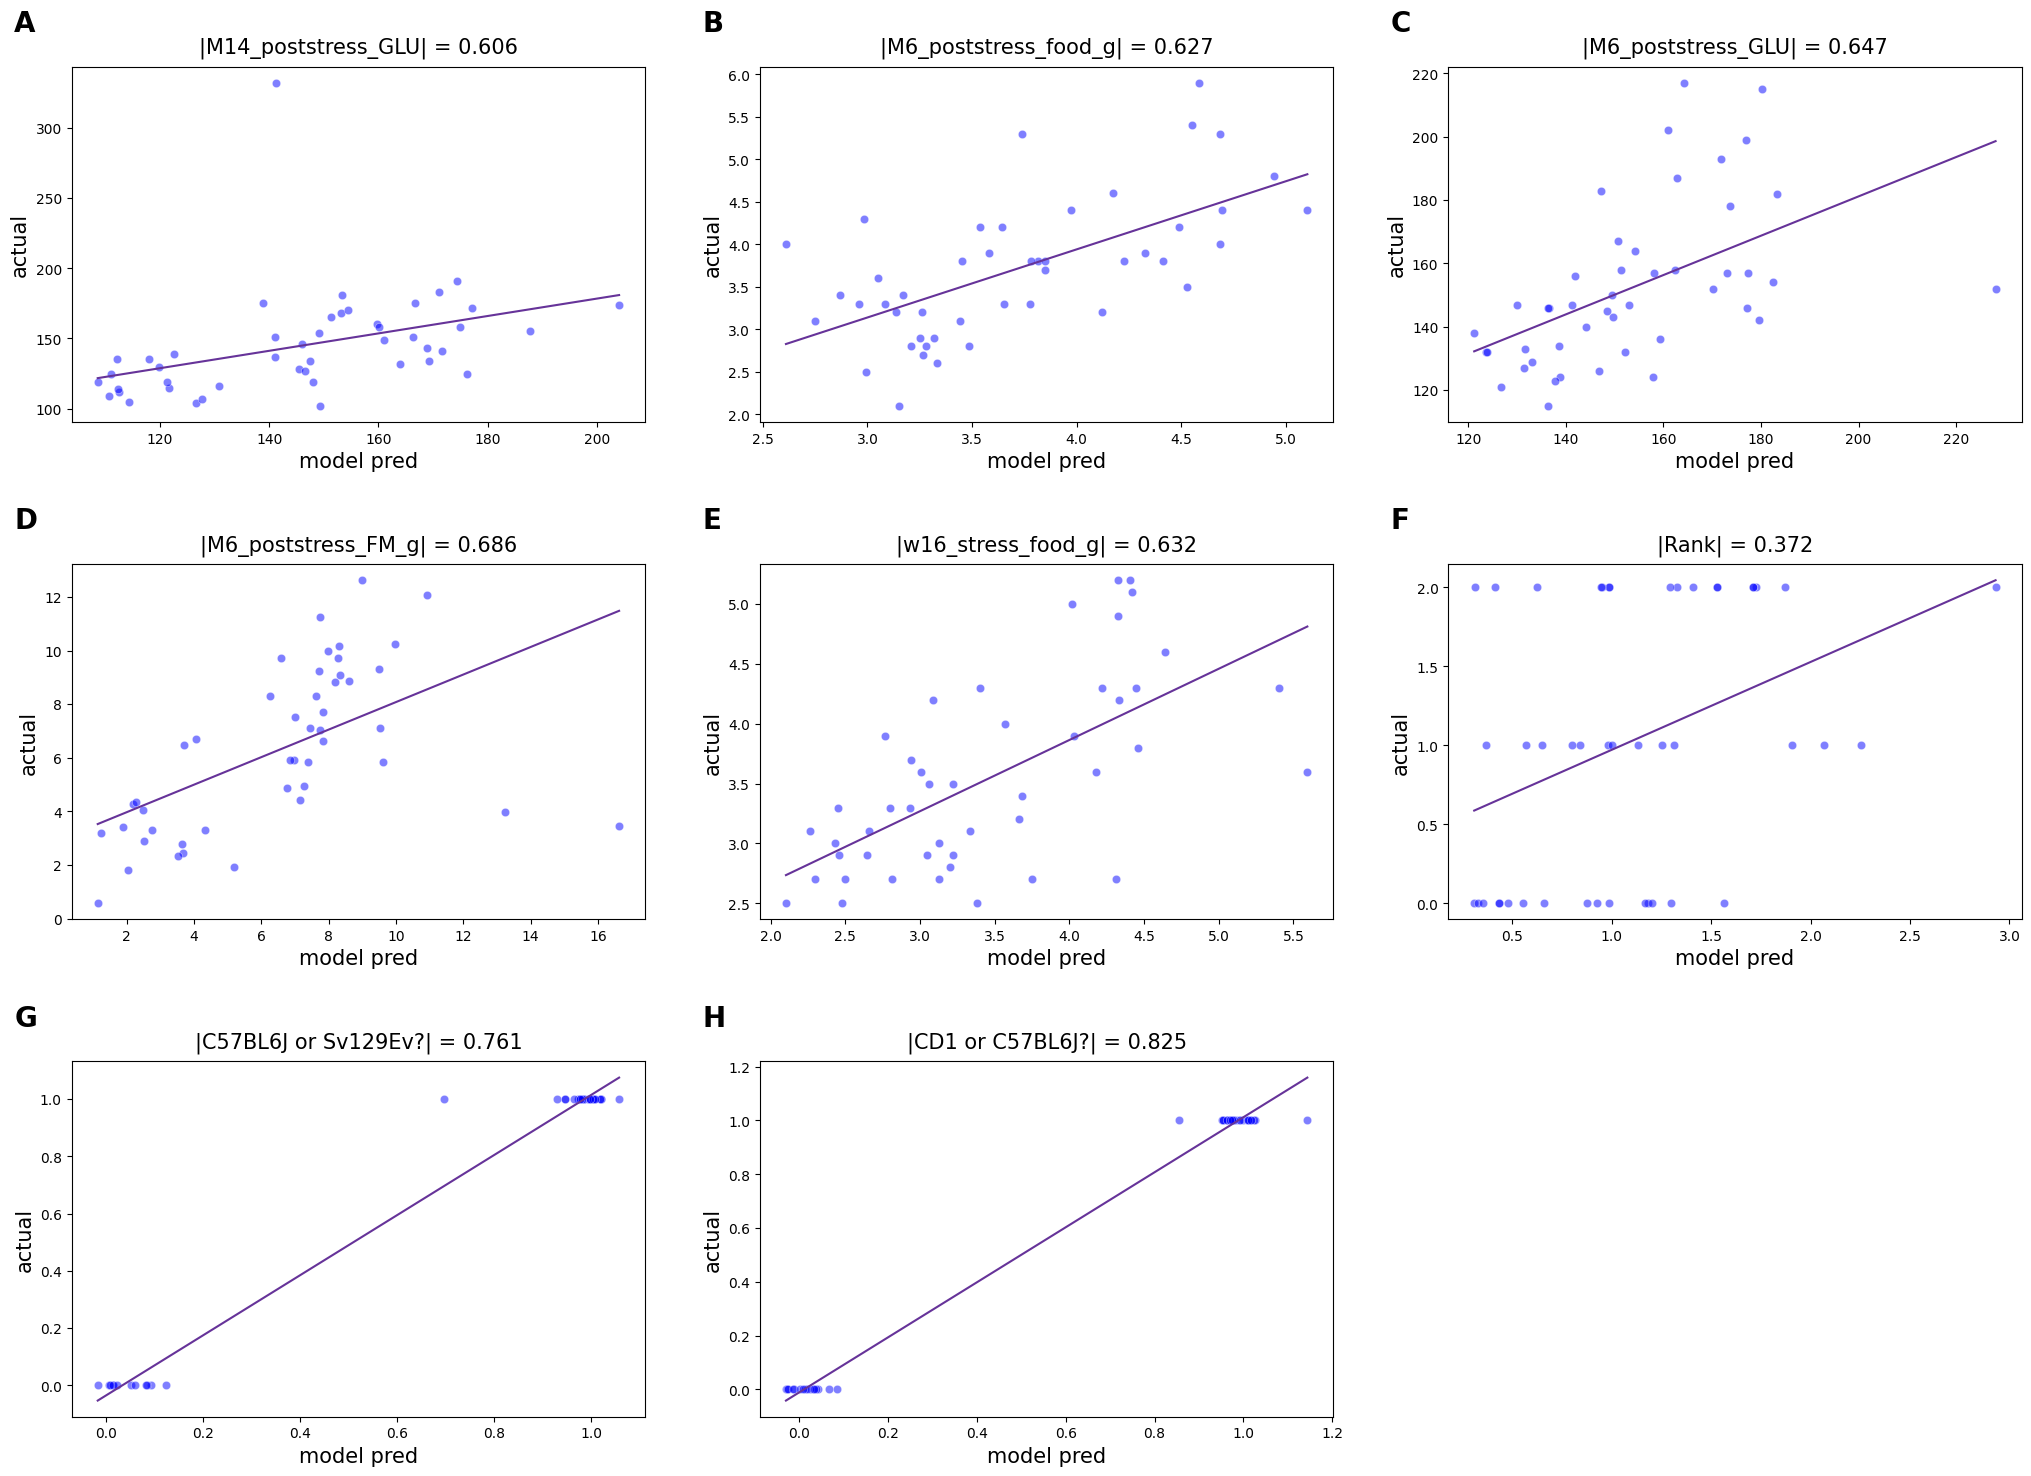

In [78]:
trait_thresh = 0.60
probe_thresh = 0.50
pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
             find_meth=False, probe_thresh=probe_thresh);

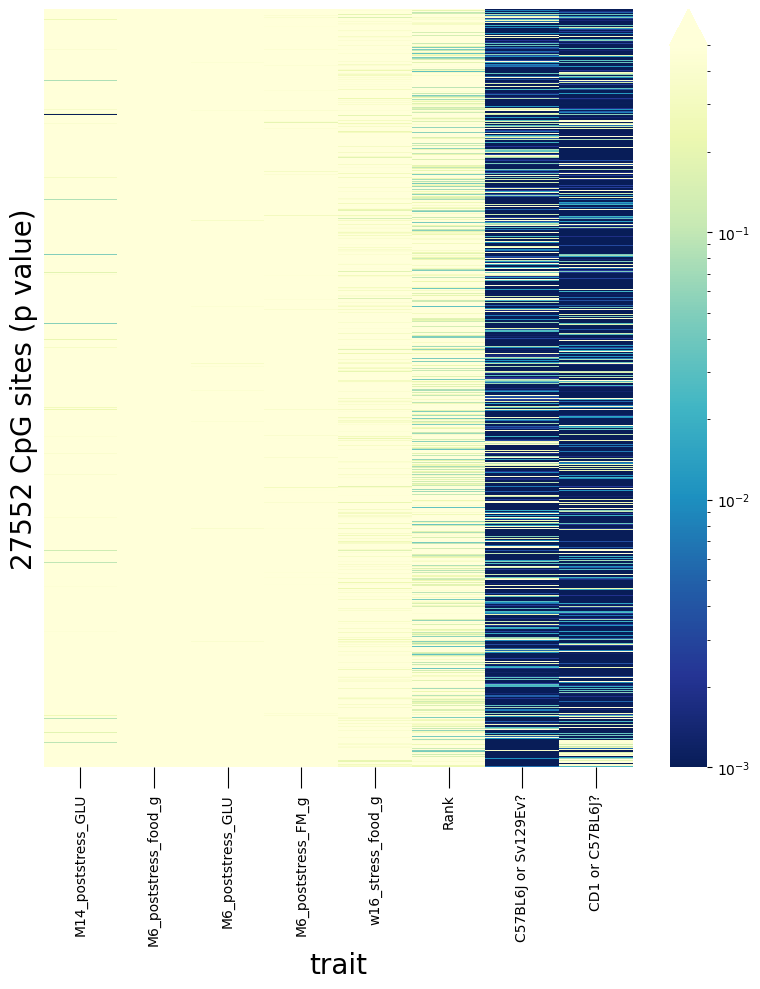

In [79]:
# generate heatmap of probe/trait MMR AdjP values
probe_thresh = 0.50
trait_vals, trait_pvals = pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
                                            find_meth=True, plot_results=True, 
                                            probe_thresh=probe_thresh);

In [80]:
# identify most significant probes and convert from mm39 to mm10
mm39_data = pd.read_excel('mm39_formatted_manifest.xlsx', index_col=0)
probe_df = get_pos(trait_vals, mm39_data);

In [81]:
# find how many mm39s had no equivalent conversion
non_nan_count = trait_vals['pos_mm10'].isna().sum()
print(f'there are {non_nan_count} sites without mm10 equivalents')

trait_mm10_valid = trait_vals.copy()
trait_mm10_valid = trait_mm10_valid.dropna()
trait_mm10_valid

there are 3 sites without mm10 equivalents


,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,w16_stress_food_g_pval,w16_stress_food_g_coef,...,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10
cg06259996_TC21,0.938378,-0.000040,0.99981,0.005386,0.747758,-0.000138,0.847256,-0.000650,0.795097,-0.002035,...,0.000022,-0.050829,1.038385e-04,-0.040233,chr13,78346406,78346408,chr13,78198287.0,78198289.0
cg07687349_TC21,0.931330,-0.000043,0.99981,0.004782,0.919468,-0.000048,0.845521,-0.000656,0.412872,0.005975,...,0.012236,-0.026519,2.629211e-03,-0.029170,chr2,61635281,61635283,chr2,61804937.0,61804939.0
cg11548411_BC21,0.746059,-0.000122,0.99981,0.000449,0.915732,0.000066,0.783367,-0.001221,0.887485,-0.001561,...,0.000001,-0.082743,3.010858e-06,-0.069045,chr19,45290832,45290834,chr19,45302393.0,45302395.0
cg12044283_TC21,0.866733,-0.000199,0.99981,0.017366,0.979500,-0.000042,0.888577,-0.001513,0.462731,-0.015723,...,0.005820,-0.089621,8.818038e-02,0.048109,chr19,45318466,45318468,chr19,45330027.0,45330029.0
cg12174936_BC11,0.875690,-0.000224,0.99981,-0.000199,0.836374,-0.000327,0.526193,0.007805,0.393423,0.022243,...,0.436127,-0.028806,3.031928e-03,0.102259,chr4,128637309,128637311,chr4,128743516.0,128743518.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343860_TC21,0.537211,0.000825,0.99981,0.002937,0.992942,-0.000035,0.819938,-0.005088,0.291079,-0.055247,...,0.015004,0.171389,1.020037e-09,0.525266,chrY,90771588,90771590,chrY,90760319.0,90760321.0
cg48344016_TC11,0.932758,0.000173,0.99981,0.015198,0.797940,-0.000439,0.786743,0.003657,0.228102,-0.038166,...,0.913576,-0.004693,1.704053e-09,0.312849,chrY,90813306,90813308,chrY,90802037.0,90802039.0
cg48344082_BC11,0.910113,0.000406,0.99981,0.002607,0.923150,0.000349,0.897031,-0.003504,0.524094,-0.034006,...,0.223071,0.095849,1.194404e-05,0.359502,chrY,90816641,90816643,chrY,90805372.0,90805374.0
cg48344158_BC11,0.895695,-0.000080,0.99981,0.004179,0.734534,0.000198,0.828762,-0.000996,0.842090,0.002192,...,0.019728,-0.033908,3.260864e-05,-0.060556,chrY,90820804,90820806,chrY,90809535.0,90809537.0


In [82]:
# get the number of significant probes for each trait
sig_df = insig_nan(probe_df)
non_nans = sig_df.count()

for column, name in zip(non_nans, sig_df.columns):
    if 'pval' in name:
            # print the number of non-NaN values for all other pval columns
            print(f'{name[:-5]}: {column}')

print('\n')
count_cumulative_probes(sig_df, 'C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval')
count_cumulative_probes(sig_df, 'M16_poststress_GLU_pval', 'M14_poststress_GLU_pval')

M14_poststress_GLU: 66
M6_poststress_food_g: 0
M6_poststress_GLU: 0
M6_poststress_FM_g: 0
w16_stress_food_g: 0
Rank: 12
C57BL6J or Sv129Ev?: 19669
CD1 or C57BL6J?: 20779


C57BL6J or Sv129Ev?_pval and CD1 or C57BL6J?_pval: 25110
One or both columns 'M16_poststress_GLU_pval' and 'M14_poststress_GLU_pval' are not in the DataFrame


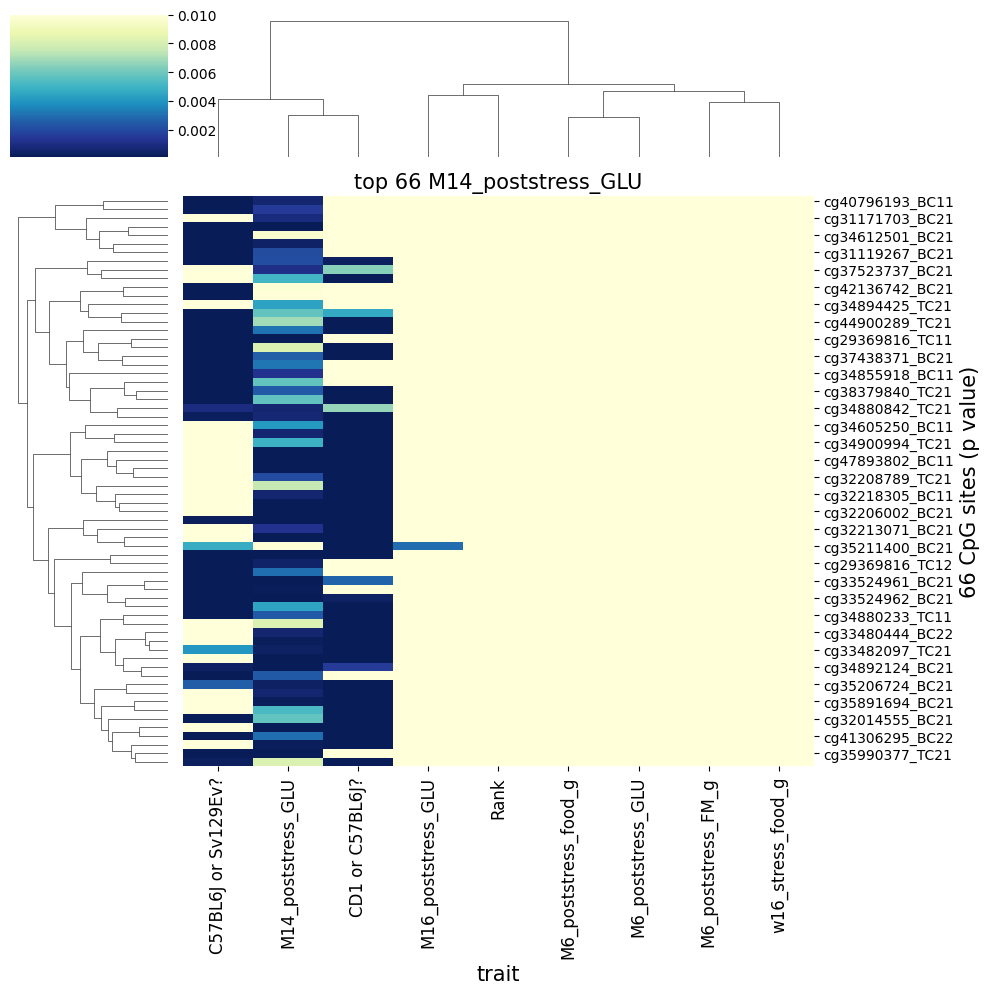

In [76]:
# generate a clustermap of significant probes the for selected trait (mm39)
sig_df = insig_nan(probe_df)
trait = 'M14_poststress_GLU_pval'

temp = sig_df[trait].values
temp = temp[~np.isnan(temp)]
n_probes = len(temp)

# add the probe names to the index
temp_pval_df = pd.DataFrame(trait_pvals)
temp_pval_df.index = trait_vals.index

trait_cluster(temp_pval_df, trait[:-5], n_probes);

In [78]:
# find gene associations of probes via GREAT

temp = probe_df.reset_index()
temp = great_analysis(temp, get='genes', df_chr ='chr_mm10', df_start='pos_mm10', df_end='end_mm10', df_index='index')

temp = temp.set_index('index')
trait_vals['associated_genes'] = temp['associated_genes']

#trait_vals.to_excel('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
trait_vals.to_excel('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
trait_vals

,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,...,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,0.451219,1.509336e-04,0.912862,-0.000034,0.995417,0.005640,0.815496,-0.000109,0.841664,-0.000686,...,-0.053731,1.102427e-05,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,0.185035,2.735580e-04,0.590319,-0.000111,0.995417,0.000910,0.835721,0.000119,0.746615,-0.001285,...,-0.088004,3.747304e-08,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,0.998784,6.839155e-07,0.993811,0.000011,0.995417,0.006266,0.975962,-0.000026,0.907243,0.000711,...,0.059890,4.024497e-09,0.119056,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,0.598747,1.895096e-04,0.995069,-0.000008,0.995417,0.006550,0.999921,0.000002,0.749642,-0.001646,...,0.057968,2.380672e-09,0.122259,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,0.499643,2.153617e-04,0.978098,-0.000024,0.995417,0.004856,0.919593,0.000081,0.623543,-0.002310,...,0.039594,2.439180e-08,0.103385,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,0.698233,-4.562673e-04,0.140620,0.000827,0.998138,0.000212,0.824306,-0.000513,0.868999,-0.003007,...,0.346442,2.644905e-02,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,0.269405,-8.102662e-04,0.981270,0.000045,0.995417,0.002629,0.991159,0.000031,0.474396,-0.008434,...,0.347546,2.142530e-01,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,0.682611,6.092711e-04,0.981270,0.000073,0.995417,0.008954,0.972244,-0.000124,0.835622,-0.004535,...,0.461462,3.851018e-01,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,0.712499,-5.957616e-04,0.390453,0.000801,0.995417,0.001933,0.968524,-0.000150,0.835351,-0.004949,...,0.182846,5.666658e-10,0.552651,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


In [81]:
# remove insignificant p values
trait_vals_no_insig = trait_vals.copy()
numeric_cols = trait_vals_no_insig.select_dtypes(include=[np.number]).columns
trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x)

# restore position info
trait_vals_no_insig['pos_mm10'] = trait_vals['pos_mm10']
trait_vals_no_insig['end_mm10'] = trait_vals['end_mm10']
trait_vals_no_insig['pos_mm39'] = trait_vals['pos_mm39']
trait_vals_no_insig['end_mm39'] = trait_vals['end_mm39']

trait_vals_no_insig

,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,...,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,NaN,1.509336e-04,NaN,-0.000034,NaN,0.005640,NaN,-0.000109,NaN,-0.000686,...,-0.053731,1.102427e-05,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,NaN,2.735580e-04,NaN,-0.000111,NaN,0.000910,NaN,0.000119,NaN,-0.001285,...,-0.088004,3.747304e-08,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,NaN,6.839155e-07,NaN,0.000011,NaN,0.006266,NaN,-0.000026,NaN,0.000711,...,NaN,4.024497e-09,NaN,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,NaN,1.895096e-04,NaN,-0.000008,NaN,0.006550,NaN,0.000002,NaN,-0.001646,...,NaN,2.380672e-09,NaN,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,NaN,2.153617e-04,NaN,-0.000024,NaN,0.004856,NaN,0.000081,NaN,-0.002310,...,NaN,2.439180e-08,NaN,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,NaN,-4.562673e-04,NaN,0.000827,NaN,0.000212,NaN,-0.000513,NaN,-0.003007,...,NaN,NaN,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,NaN,-8.102662e-04,NaN,0.000045,NaN,0.002629,NaN,0.000031,NaN,-0.008434,...,NaN,NaN,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,NaN,6.092711e-04,NaN,0.000073,NaN,0.008954,NaN,-0.000124,NaN,-0.004535,...,NaN,NaN,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,NaN,-5.957616e-04,NaN,0.000801,NaN,0.001933,NaN,-0.000150,NaN,-0.004949,...,NaN,5.666658e-10,NaN,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


In [82]:
# combine the strain-associated traits into a single column for analysis, and do the same for the blood glucose associated traits

# strain
cistrome_formatted = trait_vals_no_insig.copy()

cistrome_formatted['Strain_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['C57BL6J or Sv129Ev?_pval'], row['CD1 or C57BL6J?_pval']]) 
                        if pd.notna(row['C57BL6J or Sv129Ev?_pval']) or pd.notna(row['CD1 or C57BL6J?_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval']) # dont need to bother with coef

# blood glucose
cistrome_formatted['Blood Glucose_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['M14_poststress_GLU_pval'], row['M16_poststress_GLU_pval']]) 
                        if pd.notna(row['M14_poststress_GLU_pval']) or pd.notna(row['M16_poststress_GLU_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['M14_poststress_GLU_pval', 'M16_poststress_GLU_pval']) # dont need to bother with coef

# drop rank because it doesn't produce any factors (only 2 probes anyways)
cistrome_formatted = cistrome_formatted.drop(columns=['Rank_pval']) # dont need to bother with coef
cistrome_formatted

,M16_poststress_GLU_coef,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,w16_stress_food_g_pval,w16_stress_food_g_coef,...,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes,Strain_pval,Blood Glucose_pval
cg06259996_TC21,1.509336e-04,-0.000034,NaN,0.005640,NaN,-0.000109,NaN,-0.000686,NaN,-0.002175,...,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)",7.098023e-06,NaN
cg11548411_BC21,2.735580e-04,-0.000111,NaN,0.000910,NaN,0.000119,NaN,-0.001285,NaN,-0.001813,...,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)",3.034385e-08,NaN
cg28108944_BC11,6.839155e-07,0.000011,NaN,0.006266,NaN,-0.000026,NaN,0.000711,NaN,-0.001540,...,NaN,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)",2.670809e-04,NaN
cg28108956_TC21,1.895096e-04,-0.000008,NaN,0.006550,NaN,0.000002,NaN,-0.001646,NaN,-0.008930,...,NaN,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)",3.850879e-04,NaN
cg28108957_BC21,2.153617e-04,-0.000024,NaN,0.004856,NaN,0.000081,NaN,-0.002310,NaN,-0.001453,...,NaN,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)",2.439180e-08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,-4.562673e-04,0.000827,NaN,0.000212,NaN,-0.000513,NaN,-0.003007,NaN,-0.017001,...,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)",4.310855e-08,NaN
cg48343225_BC11,-8.102662e-04,0.000045,NaN,0.002629,NaN,0.000031,NaN,-0.008434,NaN,-0.009066,...,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)",8.600568e-10,NaN
cg48343290_TC21,6.092711e-04,0.000073,NaN,0.008954,NaN,-0.000124,NaN,-0.004535,NaN,NaN,...,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)",1.492151e-08,NaN
cg48343860_TC21,-5.957616e-04,0.000801,NaN,0.001933,NaN,-0.000150,NaN,-0.004949,NaN,-0.054697,...,NaN,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)",4.837402e-03,NaN


No valid probes, skipping trait M6_poststress_food_g_pval
No valid probes, skipping trait M6_poststress_GLU_pval
No valid probes, skipping trait M6_poststress_FM_g_pval
No valid probes, skipping trait w16_stress_food_g_pval


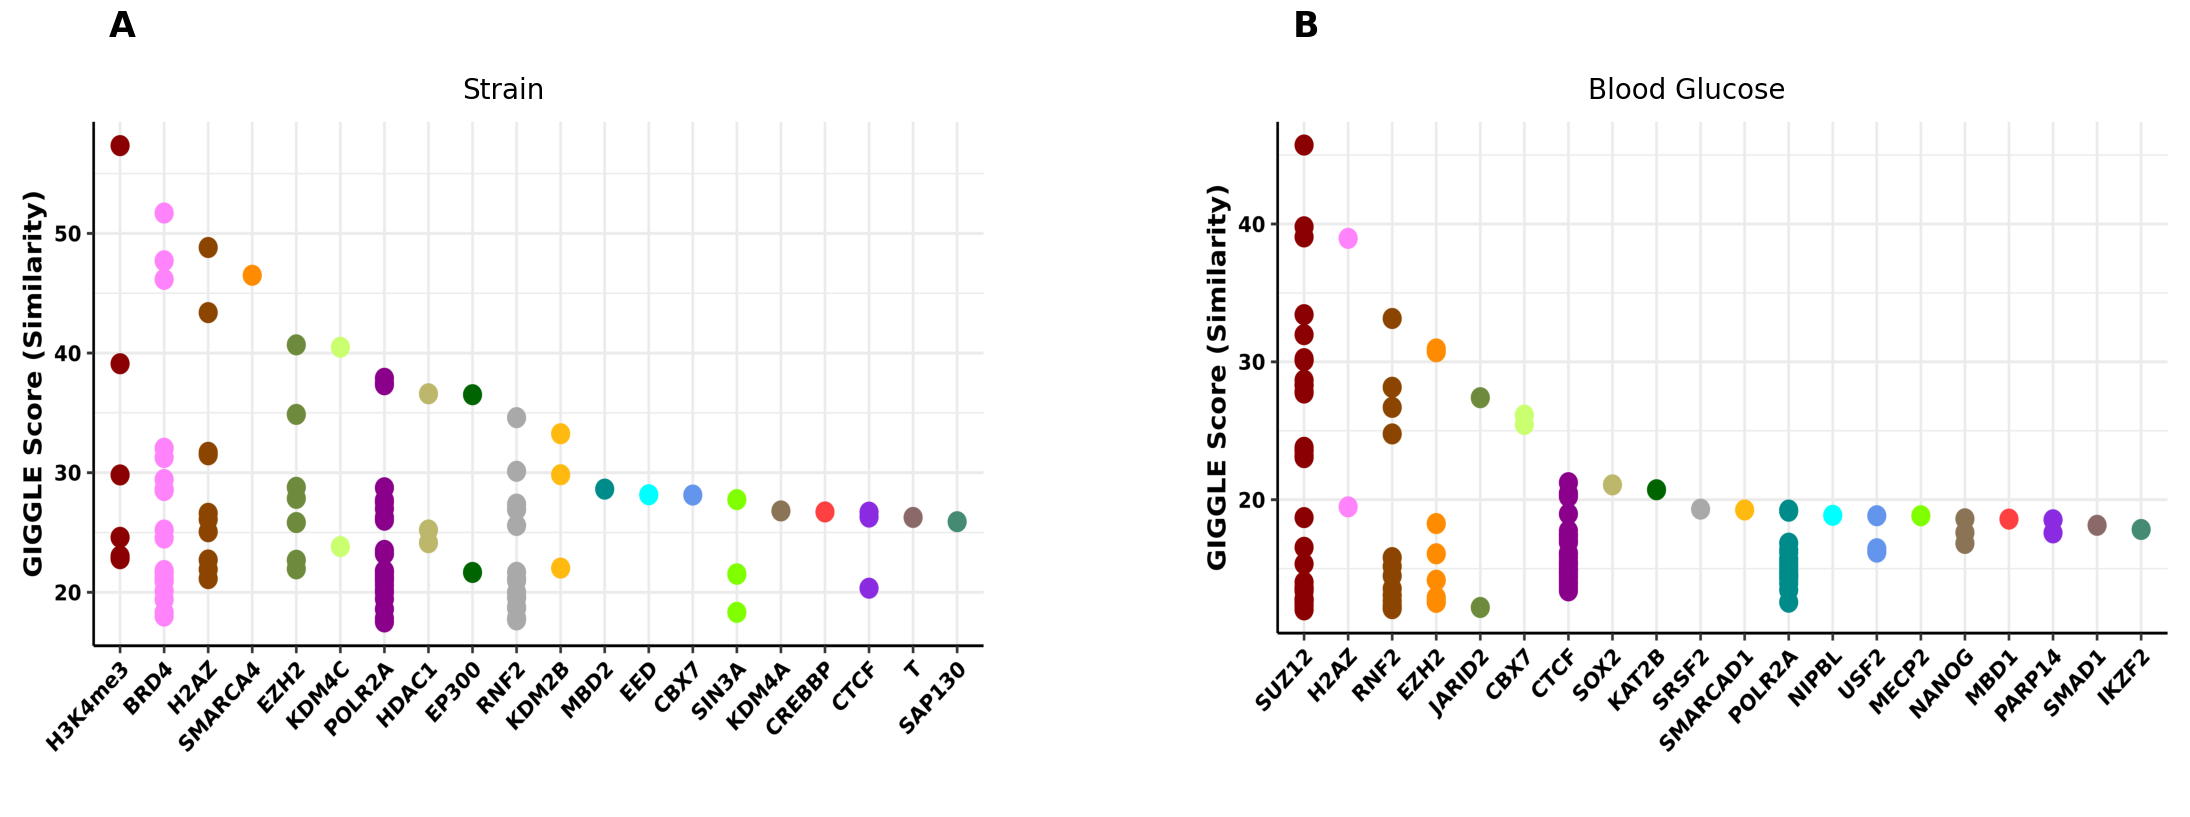

In [83]:
# get cistrome plots using probes

%matplotlib inline

# this is trial and error, unfortunately
'''
2000 for 2
3500 for 3/4
5000 for 5/6
'''
fig_w = 2800
fig_h = 2000

# generate cistrome plots by trait
get_cistrome(cistrome_formatted, fig_w, fig_h)